In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import h5py
from datetime import datetime
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
tf.config.list_physical_devices('GPU'), tf.__version__

2023-06-06 09:04:51.179626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 09:04:53.346216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/:/home/albert/miniconda3/envs/Baikal2/lib/
2023-06-06 09:04:53.34

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.11.1')

In [2]:
from osgeo import gdal, osr

In [3]:
path_to_h5 = './data/LC08_L2SP_02_T1_cropped.h5'
with h5py.File(path_to_h5, 'r') as f:
    LENGTH_OF_EPOCH = len(f['all/data_norm'])
    print('Number of small images in h5:', LENGTH_OF_EPOCH)
WIDTH = 512
HEIGHT = 512
CHANNELS = 7
CLASSES = 20
MAX_SHIFT = 1 # максимальное смещение по вертикали и горизонтали в функции потерь
BATCH_SIZE = 2

Number of small images in h5: 9075


### 1. Data loading

In [4]:
class BatchLoader:
    def __init__(self,path_to_h5, batch_size):
        self.path = path_to_h5
        self.bs = batch_size
        with h5py.File(self.path, 'r') as f:
            self.num = f['all/data_norm'].shape[0]
        self.batch_num = self.num // self.bs

    def __call__(self):
        for i in range(self.batch_num):
            with h5py.File(self.path, 'r') as f:
                start = i * self.bs
                stop = start + self.bs
                batch = f['all/data_norm'][start:stop]
            yield batch

def make_train_dataset(path_to_h5, batch_size):
    BL = BatchLoader(path_to_h5, batch_size)
    train_dataset = tf.data.Dataset.from_generator(
        BL,
        output_signature=(tf.TensorSpec(shape=(batch_size, WIDTH, HEIGHT, CHANNELS)))
    )
    train_dataset = train_dataset.repeat(-1).prefetch(tf.data.AUTOTUNE) #хранение в логах для ускорения обучения
    return train_dataset

### 2. Transformations

In [5]:
def generate_affine_transform_params(batch_size, size = WIDTH):
    pi = np.pi

    # generate rotation angle
    refl_index = tf.math.round(tf.random.uniform((batch_size,), minval=0, maxval=1, dtype=tf.float32))*2.-1.
    theta = tf.random.uniform((batch_size,), minval = -pi, maxval = pi, dtype = 'float32')
    
    c1 = tf.cos(theta)
    s1 = -tf.sin(theta)*refl_index
    s2 = tf.sin(theta)
    c2 = tf.cos(theta)*refl_index
    
    rot_matrix = tf.convert_to_tensor([[c1, s1],[s2, c2] ])
    rot_matrix = tf.transpose( rot_matrix, perm=(2,0,1) )
    inv_rot_matrix = tf.convert_to_tensor([ [c1, s2],[s1, c2] ])
    inv_rot_matrix = tf.transpose( inv_rot_matrix, perm=(2,0,1) )
    c_fin = tf.convert_to_tensor([ [size/np.sqrt(2)], [size/np.sqrt(2)] ], dtype = 'float32')
    c_in = tf.convert_to_tensor([[ size/2], [size/2] ], dtype = 'float32')
    c_rot = tf.linalg.matmul( rot_matrix, c_in  )
    delta = tf.linalg.matmul( inv_rot_matrix, c_fin - c_rot )
    x_shift = -delta[:,0,0]
    y_shift = -delta[:,1,0]
    
    # For (x, y) = T(x', y'):
    inverse_params = tf.stack([
        c1,  s1, -x_shift*c1-y_shift*s1,
        s2,  c2, -y_shift*c2-x_shift*s2,
        tf.zeros(batch_size), tf.zeros(batch_size)
    ], axis = 1)

    # For (x', y') = T(x, y):
    params = tf.stack([
         c1, s2, x_shift,
         s1, c2, y_shift,
        tf.zeros(batch_size), tf.zeros(batch_size)
    ], axis = 1)
    return params, inverse_params

class RandomAffineTransformParams(tf.keras.layers.Layer):
    def call(self, inp):
        return generate_affine_transform_params(tf.shape(inp)[0])
    
class ImageProjectiveTransformLayer(tf.keras.layers.Layer):
    def __init__(self, interpolation='BILINEAR', fill_value=0, **kwargs):
        super(ImageProjectiveTransformLayer, self).__init__(**kwargs)
        self.interpolation = interpolation
        self.fill_value = fill_value

    def call(self, inputs, transforms):
        S1,S2 = WIDTH, HEIGHT
        if inputs.shape[1] != None and inputs.shape[1] > S1:
            return tf.raw_ops.ImageProjectiveTransformV3(
                images=inputs,
                transforms=transforms,
                output_shape=tuple((S1,S2)),
                interpolation=self.interpolation,
                fill_value=self.fill_value
            )
        else:
            #S1 *=np.sqrt(2)
            #S2 *=np.sqrt(2)
            out_shape = tuple((736, 736))
            return tf.raw_ops.ImageProjectiveTransformV3(
                images=inputs,
                transforms=transforms,
                output_shape=out_shape,
                interpolation=self.interpolation,
                fill_value=self.fill_value
            )

### 3. Creating model

In [6]:
def conv_block(x, num_filters, kernel):
    x = Conv2D(num_filters, kernel, padding="same")(x)
    x = BatchNormalization(axis = -1)(x)
    x = Activation("relu")(x)
    return x

def encoder_block(x, num_filters, k_conv = 3, s = 2):
    x = conv_block(x, num_filters, k_conv)
    p = Conv2D(num_filters, k_conv, strides = s, padding="same")(x)
    p = BatchNormalization(axis = -1)(p)
    p = Activation("relu")(p)
    return x, p

def decoder_block(x, skip_features, num_filters, k_conv = 3, stride = 2):
    x = Conv2DTranspose(num_filters, k_conv, strides=stride, padding="same")(x)
    x = Concatenate()([x, skip_features])
    x = BatchNormalization(axis = -1)(x)
    x = Activation("relu")(x)
    x = conv_block(x, num_filters, k_conv)
    return x

def res_block(x, f, k):
    x_skip = x
    x_skip = conv_block(x_skip, f, k)
    x = conv_block(x, f, k)
    x = conv_block(x, f, k)
    x = Add()([x, x_skip])
    x = BatchNormalization(axis = -1)(x)
    x = Activation("relu")(x)
    return x

#Задаём фильтры и размеры ядер на этапе создания модели
def build_unet(filters, conv_kernel, strides):
    inputs = Input(shape = (None, None, CHANNELS))

    s1, p1 = encoder_block(inputs, filters[0], conv_kernel[0], strides[0])
    s2, p2 = encoder_block(p1, filters[1], conv_kernel[1], strides[1])
    s3, p3 = encoder_block(p2, filters[2], conv_kernel[2], strides[2])
    s4, p4 = encoder_block(p3, filters[3], conv_kernel[3], strides[3])

    b1 = conv_block(p4, filters[4], conv_kernel[4])

    d1 = decoder_block(b1, s4, filters[3], conv_kernel[3], stride = strides[3])
    d2 = decoder_block(d1, s3, filters[2], conv_kernel[2], stride = strides[2])
    d3 = decoder_block(d2, s2, filters[1], conv_kernel[1], stride = strides[1])
    d4 = decoder_block(d3, s1, filters[0], conv_kernel[0], stride = strides[0])

    outputs = Conv2D(CLASSES, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

def build_resnet(filters, conv_kernel):
    inputs = Input(shape = (None, None, CHANNELS))

    x = res_block(inputs, filters[0], conv_kernel[0])
    x = res_block(x, filters[1], conv_kernel[1])
    x = res_block(x, filters[2], conv_kernel[2])

    outputs = Conv2D(CLASSES, 1, padding="same", activation="softmax")(x)

    model = Model(inputs, outputs, name="ResNet")
    return model

def simple_classifier():
    inp = tf.keras.layers.Input(shape = (None, None, CHANNELS)) # 512x512x7
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(inp)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    c = tf.keras.layers.Conv2D(CLASSES, 1, padding = 'same', activation = 'softmax')(x)
    return tf.keras.Model(inputs = inp, outputs = c)

In [7]:
###Задаём фильтры и размеры ядер на этапе создания модели
###Список 'filters' - кол-во фильтров, по порядку следования слоёв 'encoder'
###Список 'conv_kernels' - размер ядер свёрток в 'encoder' и 'decoder', по порядку следования слоёв 'encoder'
###Список 'strides' - размер 'strides' в 'encoder' и 'decoder', по порядку следования слоёв 'encoder'
def make_model(filters = [64,64,64], conv_kernel = [3,3,3]):#, strides = [2,2,2,2]):
    
    #Создаём основу модели
    inp = tf.keras.layers.Input(shape=(None, None, CHANNELS))
    
    #classifier = simple_classifier()
    classifier = build_resnet(filters, conv_kernel)
    #classifier = build_unet(filters, conv_kernel, strides)

    outp = classifier(inp)
    model = tf.keras.Model(inputs=inp, outputs=outp)
    
    #По гиперпараметрам генерируем имя модели
    s = 'f'
    for i in filters:
        s +='.'+str(i)
    s+='_k'
    for i in conv_kernel:
        s +='.'+str(i)
    s+='_s'
    #for i in strides:
    #    s +='.'+str(i)
    
    model_name = str(classifier.name)+'_'+s+'_CLASSES.'+str(CLASSES)+'_BS.'+str(BATCH_SIZE)
    
    #Алгоритм подсчёта лосса
    params, inverse_params = RandomAffineTransformParams()(inp)
    transformed_inp = ImageProjectiveTransformLayer()(inp, params)
    transformed_outp = classifier(transformed_inp)
    inv_transformed_outp = ImageProjectiveTransformLayer()(transformed_outp, inverse_params)
    model.add_loss(conv_loss(outp, inv_transformed_outp))
    
    return model, model_name

### 4. Visualising

In [8]:
def transorm_point_to_latlong(x,y):
    
    # projective coordinate system
    old_cs_config = """
    PROJCS["WGS 84 / UTM zone 39N",
        GEOGCS["WGS 84",
            DATUM["WGS_1984",
                SPHEROID["WGS 84",6378137,298.257223563,
                    AUTHORITY["EPSG","7030"]],
                AUTHORITY["EPSG","6326"]],
            PRIMEM["Greenwich",0,
                AUTHORITY["EPSG","8901"]],
            UNIT["degree",0.0174532925199433,
                AUTHORITY["EPSG","9122"]],
            AUTHORITY["EPSG","4326"]],
        PROJECTION["Transverse_Mercator"],
        PARAMETER["latitude_of_origin",0],
        PARAMETER["central_meridian",51],
        PARAMETER["scale_factor",0.9996],
        PARAMETER["false_easting",500000],
        PARAMETER["false_northing",0],
        UNIT["metre",1,
            AUTHORITY["EPSG","9001"]],
        AXIS["Easting",EAST],
        AXIS["Northing",NORTH],
        AUTHORITY["EPSG","32639"]]
    """
    old_cs = osr.SpatialReference()
    old_cs .ImportFromWkt(old_cs_config)
    
    # create the new coordinate system
    wgs84_wkt = """
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs .ImportFromWkt(wgs84_wkt)
    
    
    # create a transform object to convert between coordinate systems
    transform = osr.CoordinateTransformation(old_cs,new_cs) 
    #get the coordinates in lat long
    latlong = transform.TransformPoint(x,y)
    return latlong

In [9]:
def draw_result(img_no):
    with h5py.File(path_to_h5, 'r') as f:
        MEAN = f['all/norm_params/mean_values'][:]
        SIGMA = f['all/norm_params/sigma_values'][:]
        GEO = f['all/geo_coords'][img_no]
        GEO = transorm_point_to_latlong(*GEO)
        img_norm = f['all/data_norm'][img_no,:,:,:]
        img = (img_norm*SIGMA + MEAN) / 2**16

    def renorm(img, axis=(0, 1)):
        img_min = img.min(axis)
        img_max = img.max(axis)
        return (img - img_min) / (img_max - img_min)

    plt.figure(figsize=(8, 8))
    plt.suptitle('X = '+ str(np.round(GEO[0],5))+'; Y = '+ str(np.round(GEO[1], 5)))

    plt.subplot(2, 2, 1)
    plt.imshow(img[:, :, 5:2:-1])

    plt.subplot(2, 2, 2)
    plt.imshow(predicted_classes[img_no])
    plt.show()
    
def get_rgb_image(img_no):
    with h5py.File(path_to_h5, 'r') as f:
        MEAN = f['all/norm_params/mean_values'][:]
        SIGMA = f['all/norm_params/sigma_values'][:]
        GEO = f['all/geo_coords'][img_no]
        img_norm = f['all/data_norm'][img_no,:,:,:]
    img = (img_norm*SIGMA + MEAN) / 2**16
    return img[:, :, 5:2:-1]

def get_image(start, stop):
    with h5py.File(path_to_h5, 'r') as f:
        MEAN = f['all/norm_params/mean_values'][start:stop]
        SIGMA = f['all/norm_params/sigma_values'][start:stop]
        GEO = f['all/geo_coords'][start:stop]
        img_norm = f['all/data_norm'][start:stop,:,:,:]
    img = (img_norm*SIGMA + MEAN) / 2**16
    return img, GEO

def get_norm_image(start, stop):
    with h5py.File(path_to_h5, 'r') as f:
        GEO = f['all/geo_coords'][start:stop]
        img_norm = f['all/data_norm'][start:stop,:,:,:]
    return img_norm, GEO

def draw_layers(img_no, predicted_classes, opacity=0.3):
    
    with h5py.File(path_to_h5, 'r') as f:
        GEO = f['all/geo_coords'][img_no]
    GEO = transorm_point_to_latlong(*GEO)
    
    fig = make_subplots(rows=1, cols=3,
                        subplot_titles=("Original Image", "Classes", "Overlay", ""))
    rgb = get_rgb_image(img_no)
    
    fig.add_trace(px.imshow(rgb).data[0], 
                  row = 1,
                  col = 1)
    fig.add_trace(px.imshow(rgb).data[0], 
                  row = 1,
                  col = 2)
    fig.add_trace(px.imshow(rgb).data[0], 
                  row = 1,
                  col = 3)

    for i in range(CLASSES):
        class_mask = np.where(predicted_classes[img_no] == i, i, np.nan)
        fig.add_trace(
            go.Heatmap(
                z=class_mask, 
                colorscale=[[0, f"hsv({i*360/20},100%,100%)"], [1, f"hsv({i*360/20},100%,100%)"]],
                hoverongaps=False,
                showscale=False,
                showlegend=True,
                name=f"Class {i}",
                opacity=1
            ), row=1, col=2)
        fig.add_trace(
            go.Heatmap(
                z=class_mask, 
                colorscale=[[0, f"hsv({i*360/20},100%,100%)"], [1, f"hsv({i*360/20},100%,100%)"]],
                hoverongaps=False,
                showscale=False,
                showlegend=False,
                name=f"Class {i}",
                opacity=opacity
            ), row=1, col=3)
        
    fig.update_layout(title_text="GEO COORDS: Lat = "+str(np.round(GEO[0], 5)) +' Long = '+str(np.round(GEO[1], 5)))
    
    return fig

### 3. Main part

In [10]:
model_name = 'ResNet_f.64.64.64_k.3.3.3_s_CLASSES.20_BS.2'
path_to_model = './models/'+ model_name + '/best'
model = tf.keras.models.load_model(path_to_model)
#model.load_weights(path_to_model)

2023-06-06 09:04:58.442493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 09:04:58.946608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22293 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 7)]                                                              
                                                                                                  
 ResNet (Functional)            (None, None, None,   271060      ['input_3[0][0]',                
                                20)                               'image_projective_transform_laye
                                                                 r_4[0][0]']                      
                                                                                                  
 random_affine_transform_params  ((None, 8),         0           ['input_3[0][0]']          

 bda)                                                                                             
                                                                                                  
 add_loss_1 (AddLoss)           ()                   0           ['tf.math.reduce_mean_1[0][0]']  
                                                                                                  
Total params: 271,060
Trainable params: 269,524
Non-trainable params: 1,536
__________________________________________________________________________________________________


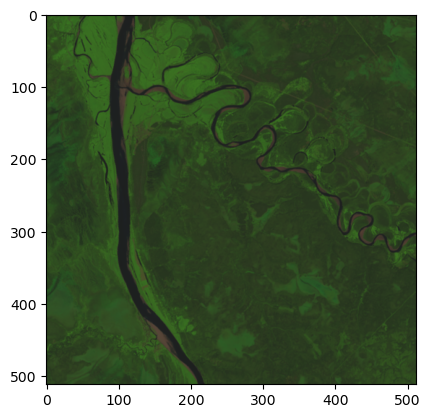

In [48]:
no = 6
start = 0
stop = 100
img, GEO = get_image(start,stop)
img_norm, GEO = get_norm_image(start,stop)
plt.imshow(img[no,:, :, 5:2:-1])

In [49]:
predicted = model.predict(img_norm, verbose = False)
predicted_classes = predicted.argmax(axis = -1)

2023-06-04 15:33:05.097652: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2097152000 exceeds 10% of free system memory.


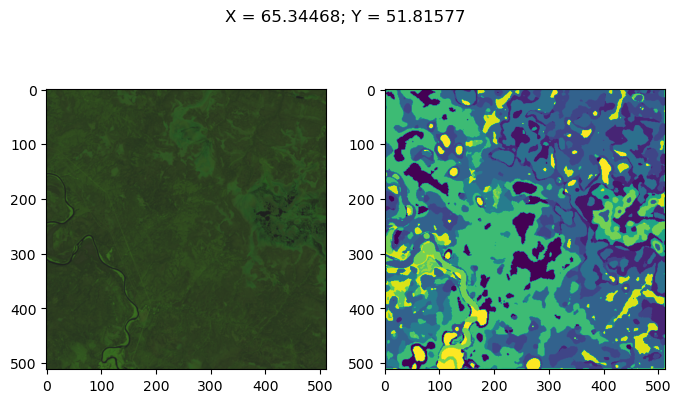

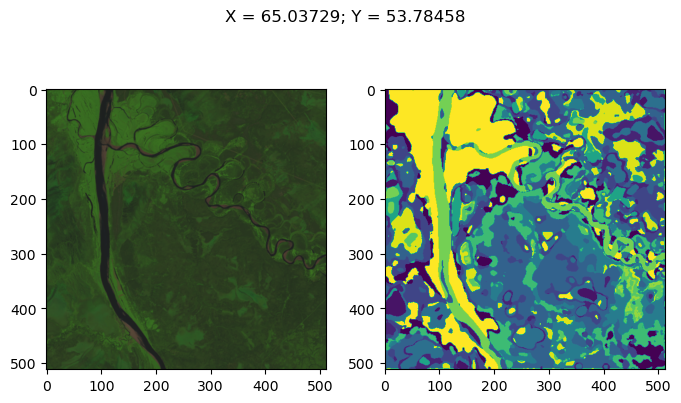

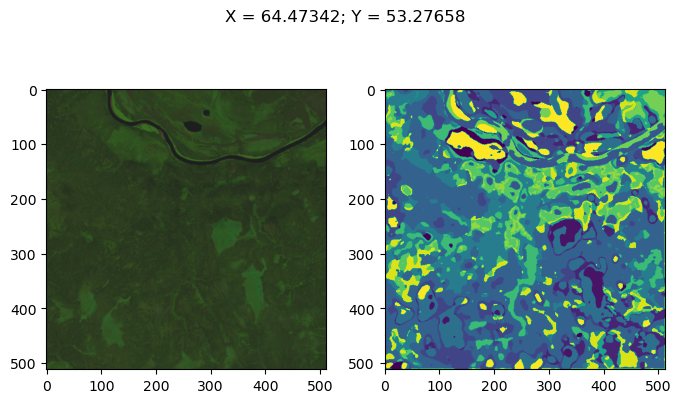

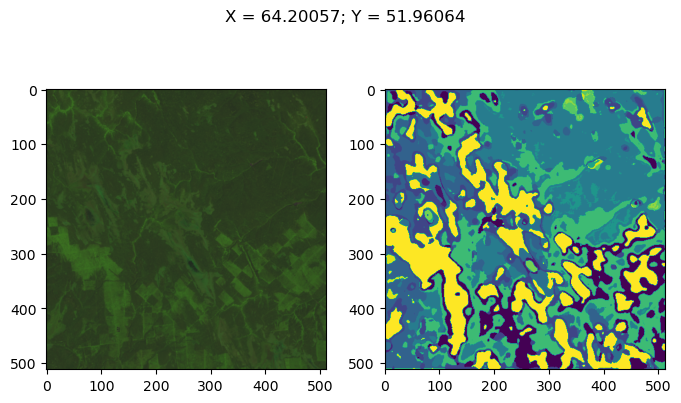

In [50]:
for i in [0,6, 50, 80]:
    draw_result(i)

In [51]:
for n,i in enumerate([0, 6, 50, 80]):
    f = draw_layers(i, predicted_classes)
    f.write_html('./f_to_send_'+str(n)+'.html')